In [1]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch import nn 
import numpy as np
import shutil
import torch
import os

## Setup directory

In [2]:
# setup directory
dir_path = './data/sea_animal/'
os.makedirs(os.path.join(dir_path,'train'), exist_ok=True)
os.makedirs(os.path.join(dir_path,'val'), exist_ok=True)
os.makedirs(os.path.join(dir_path,'test'), exist_ok=True)

In [3]:
class_names = os.listdir(dir_path)
class_names.remove('train')
class_names.remove('val')
class_names.remove('test')

In [4]:
for class_ in class_names :
    if not os.path.exists(os.path.join(dir_path, 'train', class_)) :
        full_path = os.path.join(dir_path, class_)
        images_path = [os.path.join(dir_path, class_, name) for name in os.listdir(full_path)]
        num_image = len(images_path)
        train_size = int(num_image * 0.70)
        val_size = int(num_image * 0.15)
        train_path = images_path[:train_size]
        val_path = images_path[train_size:train_size+val_size]
        test_path = images_path[train_size+val_size:]
        
        # create main folder
        train_des = os.path.join(dir_path, 'train', class_)
        val_des = os.path.join(dir_path, 'val', class_)
        test_des = os.path.join(dir_path, 'test', class_)
        for des in [train_des, val_des, test_des] :
            os.makedirs(des, exist_ok=True)
        
        # move images to train val test folder
        for image in train_path :
            shutil.move(image, train_des)
        for image in val_path :
            shutil.move(image, val_des)
        for image in test_path :
            shutil.move(image, test_des)

## Images to tensor

In [5]:
# setup train val test path
train_path = os.path.join(dir_path, 'train')
val_path = os.path.join(dir_path, 'val')
test_path = os.path.join(dir_path, 'test')

In [6]:
# transform images to tensor
train_transformer = transforms.Compose([ 
    transforms.Resize((64,64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])
val_test_transformer = transforms.Compose([ 
    transforms.Resize((64,64)),
    transforms.ToTensor()
])

train_images = datasets.ImageFolder(root=train_path, transform=train_transformer, target_transform=None)
val_images = datasets.ImageFolder(root=val_path, transform=val_test_transformer, target_transform=None)
test_images = datasets.ImageFolder(root=test_path, transform=val_test_transformer, target_transform=None)

len(train_images), len(val_images), len(test_images)

(8212, 1752, 1778)

In [7]:
class_names = train_images.classes

In [8]:
BATCH_SIZE = 32
train_dataloader = DataLoader(dataset=train_images, batch_size=BATCH_SIZE, num_workers=os.cpu_count(), shuffle=True)
val_dataloader = DataLoader(dataset=val_images, batch_size=BATCH_SIZE, num_workers=os.cpu_count(), shuffle=True)
test_dataloader = DataLoader(dataset=test_images, batch_size=BATCH_SIZE, num_workers=os.cpu_count(), shuffle=False)

In [9]:
img, label = next(iter(train_dataloader))

print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([32, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([32])


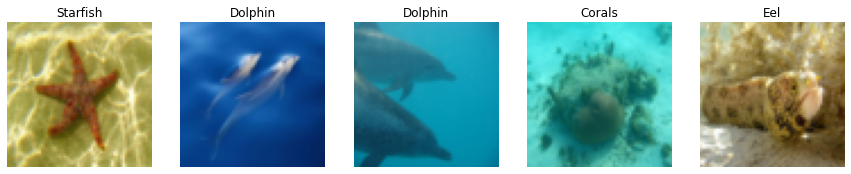

In [10]:
random_idx = np.random.permutation(BATCH_SIZE)
plt.figure(figsize=(15,30))
for sample_image in range(5) :
    idx = random_idx[sample_image]
    plt.subplot(1,5,sample_image+1)
    plt.imshow(img[idx].permute(1,2,0));
    plt.title(class_names[label[idx]])
    plt.axis('off')

## Create Model

In [11]:
class SeaAnimalModel(nn.Module) :
    def __init__(self, no_channel, hidden_units, no_class ):
        super().__init__()
        
        self.conv2d_1 = nn.Conv2d(no_channel, hidden_units, kernel_size=(5,5), padding='valid')
        self.maxpool = nn.MaxPool2d((2,2))
        self.relu = nn.ReLU()
        self.conv2d_2 = nn.Conv2d(hidden_units, hidden_units, kernel_size=(3,3), padding='same')
        self.flatten = nn.Flatten()
        self.dense = nn.Linear(hidden_units*15*15, no_class)
    
    def forward(self, x) :
        x = self.conv2d_1(x)
        x = self.maxpool(x)
        x = self.relu(x)
        x = self.conv2d_2(x)
        x = self.maxpool(x)
        x = self.relu(x)
        x = self.flatten(x)
        x = self.dense(x)
        return x

In [12]:
modelTester = SeaAnimalModel(no_channel=3, hidden_units=8, no_class=3)
modelTester(img)[:5]

tensor([[-0.0167, -0.0680,  0.0243],
        [-0.0985, -0.0536,  0.0234],
        [-0.0556, -0.0403,  0.0174],
        [-0.0417, -0.0614,  0.0023],
        [-0.1146, -0.0421,  0.0082]], grad_fn=<SliceBackward0>)

## Train Model

In [13]:
def train_step(model, dataloader, loss_fn, optimizer) :
    model.train()
    train_loss, train_acc = 0, 0
    
    for batch, (x,y) in enumerate(dataloader) :
        y_pred = model(x)
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item() / len(y_pred)

    # take avg for each batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

In [14]:
def test_step(model, dataloader, loss_fn) :
    model.eval()
    test_loss, test_acc = 0, 0

    with torch.inference_mode() :
        for batch, (x,y) in enumerate(dataloader) :
            y_pred = model(x)
            loss = loss_fn(y_pred, y)
            test_loss += loss.item()

            y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
            test_acc += (y_pred_class == y).sum().item() / len(y_pred)

    # take avg for each batch
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc        

In [15]:
def train_model(model, train_dataloader, val_dataloader, loss_fn, optimizer, epochs, model_name, pre_result=None, pre_epoch=0, best_loss=np.Infinity) :
    
    if not pre_result :
        results = {
            'train_loss' : [],
            'train_acc' : [],
            'val_loss' : [],
            'val_acc' : []
        }
    else :
        results = pre_result.copy()

    for epoch in tqdm(range(epochs)) :
        train_loss, train_acc = train_step(model, train_dataloader, loss_fn, optimizer)
        val_loss, val_acc = test_step(model, val_dataloader, loss_fn)

        if val_loss < best_loss :
            best_loss = val_loss
            save_path = f'./save_model/model_checkpoint/best_{model_name}.pth'
            torch.save(model.state_dict(), save_path)
            print(f' -- save model to : {save_path}')
        
        print(
            f'Epoch : {epoch+1+pre_epoch} | '
            f'train_acc : {train_acc:.4f} |'
            f'train_loss : {train_loss:.4f} |'
            f'val_acc : {val_acc:.4f} |'
            f'val_loss : {val_loss:.4f} '
        )
    
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["val_loss"].append(val_loss)
        results["val_acc"].append(val_acc)
    
    return results

In [152]:
from timeit import default_timer as timer

NUM_EPOCHS = 5
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

modelV1 = SeaAnimalModel(no_channel=3, hidden_units=8, no_class=len(class_names))
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=modelV1.parameters(), lr=0.01)

start_time = timer()
modelV1_result = train_model(modelV1, train_dataloader, val_dataloader, loss_fn, optimizer, NUM_EPOCHS, 'SeaAnimalModel')
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

 20%|██        | 1/5 [00:42<02:49, 42.38s/it]

 -- save model to : ./save_model/model_checkpoint/best_SeaAnimalModel.pth
Epoch : 1 | train_acc : 0.1656 |train_loss : 2.7804 |val_acc : 0.2061 |val_loss : 2.7070 


 40%|████      | 2/5 [01:14<01:48, 36.21s/it]

 -- save model to : ./save_model/model_checkpoint/best_SeaAnimalModel.pth
Epoch : 2 | train_acc : 0.2248 |train_loss : 2.5673 |val_acc : 0.2205 |val_loss : 2.5751 


 60%|██████    | 3/5 [01:45<01:07, 33.95s/it]

 -- save model to : ./save_model/model_checkpoint/best_SeaAnimalModel.pth
Epoch : 3 | train_acc : 0.2589 |train_loss : 2.3907 |val_acc : 0.2443 |val_loss : 2.5133 


 80%|████████  | 4/5 [02:16<00:32, 32.69s/it]

 -- save model to : ./save_model/model_checkpoint/best_SeaAnimalModel.pth
Epoch : 4 | train_acc : 0.2752 |train_loss : 2.3222 |val_acc : 0.2568 |val_loss : 2.4820 


100%|██████████| 5/5 [02:46<00:00, 33.38s/it]

 -- save model to : ./save_model/model_checkpoint/best_SeaAnimalModel.pth
Epoch : 5 | train_acc : 0.2955 |train_loss : 2.2719 |val_acc : 0.2703 |val_loss : 2.4003 
Total training time: 166.918 seconds


Continue train | adjust some parameters

In [153]:
NUM_EPOCHS = 5
optimizer = torch.optim.SGD(params=modelV1.parameters(), lr=0.02)

start_time = timer()
modelV1_result = train_model(modelV1, train_dataloader, val_dataloader, loss_fn, optimizer, NUM_EPOCHS, 'SeaAnimalModel')
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

 20%|██        | 1/5 [00:32<02:09, 32.47s/it]

 -- save model to : ./save_model/model_checkpoint/best_SeaAnimalModel.pth
Epoch : 1 | train_acc : 0.2872 |train_loss : 2.2930 |val_acc : 0.2617 |val_loss : 2.4381 


 40%|████      | 2/5 [01:05<01:38, 32.96s/it]

Epoch : 2 | train_acc : 0.3017 |train_loss : 2.2455 |val_acc : 0.2265 |val_loss : 2.4625 


 60%|██████    | 3/5 [01:36<01:04, 32.08s/it]

Epoch : 3 | train_acc : 0.3160 |train_loss : 2.2211 |val_acc : 0.2801 |val_loss : 2.4827 


 80%|████████  | 4/5 [02:07<00:31, 31.71s/it]

Epoch : 4 | train_acc : 0.3279 |train_loss : 2.1925 |val_acc : 0.2345 |val_loss : 2.4604 


100%|██████████| 5/5 [02:38<00:00, 31.71s/it]

 -- save model to : ./save_model/model_checkpoint/best_SeaAnimalModel.pth
Epoch : 5 | train_acc : 0.3358 |train_loss : 2.1595 |val_acc : 0.2748 |val_loss : 2.3405 
Total training time: 158.561 seconds


In [154]:
NUM_EPOCHS = 5
optimizer = torch.optim.SGD(params=modelV1.parameters(), lr=0.005)

start_time = timer()
modelV1_result = train_model(modelV1, train_dataloader, val_dataloader, loss_fn, optimizer, NUM_EPOCHS, 'SeaAnimalModel_lr0.005')
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

 20%|██        | 1/5 [00:33<02:15, 33.83s/it]

 -- save model to : ./save_model/model_checkpoint/best_SeaAnimalModel_lr0.005.pth
Epoch : 1 | train_acc : 0.3651 |train_loss : 2.0486 |val_acc : 0.3063 |val_loss : 2.2365 


 40%|████      | 2/5 [01:05<01:37, 32.36s/it]

 -- save model to : ./save_model/model_checkpoint/best_SeaAnimalModel_lr0.005.pth
Epoch : 2 | train_acc : 0.3719 |train_loss : 2.0229 |val_acc : 0.3087 |val_loss : 2.2211 


 60%|██████    | 3/5 [01:37<01:04, 32.22s/it]

 -- save model to : ./save_model/model_checkpoint/best_SeaAnimalModel_lr0.005.pth
Epoch : 3 | train_acc : 0.3776 |train_loss : 2.0108 |val_acc : 0.3364 |val_loss : 2.1839 


 80%|████████  | 4/5 [02:08<00:31, 31.75s/it]

Epoch : 4 | train_acc : 0.3790 |train_loss : 1.9948 |val_acc : 0.3220 |val_loss : 2.2224 


100%|██████████| 5/5 [02:39<00:00, 32.00s/it]

 -- save model to : ./save_model/model_checkpoint/best_SeaAnimalModel_lr0.005.pth
Epoch : 5 | train_acc : 0.3812 |train_loss : 1.9878 |val_acc : 0.3413 |val_loss : 2.1624 
Total training time: 159.987 seconds


In [155]:
NUM_EPOCHS = 10
optimizer = torch.optim.SGD(params=modelV1.parameters(), lr=0.004)

start_time = timer()
modelV1_result = train_model(modelV1, train_dataloader, val_dataloader, loss_fn, optimizer, NUM_EPOCHS, 'SeaAnimalModel_lr0.004')
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

 10%|█         | 1/10 [00:34<05:09, 34.36s/it]

 -- save model to : ./save_model/model_checkpoint/best_SeaAnimalModel_lr0.004.pth
Epoch : 1 | train_acc : 0.3901 |train_loss : 1.9731 |val_acc : 0.3316 |val_loss : 2.1968 


 20%|██        | 2/10 [01:05<04:21, 32.69s/it]

 -- save model to : ./save_model/model_checkpoint/best_SeaAnimalModel_lr0.004.pth
Epoch : 2 | train_acc : 0.3894 |train_loss : 1.9627 |val_acc : 0.3339 |val_loss : 2.1670 


 30%|███       | 3/10 [01:44<04:06, 35.25s/it]

Epoch : 3 | train_acc : 0.3962 |train_loss : 1.9557 |val_acc : 0.3472 |val_loss : 2.1672 


 40%|████      | 4/10 [02:21<03:36, 36.11s/it]

 -- save model to : ./save_model/model_checkpoint/best_SeaAnimalModel_lr0.004.pth
Epoch : 4 | train_acc : 0.3942 |train_loss : 1.9479 |val_acc : 0.3559 |val_loss : 2.1398 


 50%|█████     | 5/10 [02:59<03:02, 36.59s/it]

 -- save model to : ./save_model/model_checkpoint/best_SeaAnimalModel_lr0.004.pth
Epoch : 5 | train_acc : 0.4006 |train_loss : 1.9379 |val_acc : 0.3547 |val_loss : 2.1384 


 60%|██████    | 6/10 [03:32<02:22, 35.51s/it]

Epoch : 6 | train_acc : 0.4000 |train_loss : 1.9338 |val_acc : 0.3307 |val_loss : 2.2200 


 70%|███████   | 7/10 [04:06<01:44, 34.99s/it]

Epoch : 7 | train_acc : 0.4002 |train_loss : 1.9221 |val_acc : 0.3335 |val_loss : 2.1472 


 80%|████████  | 8/10 [04:39<01:08, 34.24s/it]

Epoch : 8 | train_acc : 0.4067 |train_loss : 1.9098 |val_acc : 0.3483 |val_loss : 2.1445 


 90%|█████████ | 9/10 [05:10<00:33, 33.49s/it]

 -- save model to : ./save_model/model_checkpoint/best_SeaAnimalModel_lr0.004.pth
Epoch : 9 | train_acc : 0.4070 |train_loss : 1.9046 |val_acc : 0.3636 |val_loss : 2.1152 


100%|██████████| 10/10 [05:42<00:00, 34.28s/it]

 -- save model to : ./save_model/model_checkpoint/best_SeaAnimalModel_lr0.004.pth
Epoch : 10 | train_acc : 0.4113 |train_loss : 1.8946 |val_acc : 0.3532 |val_loss : 2.1114 
Total training time: 342.833 seconds


load best model and continue train

In [22]:
# load best model 
modelV1_loaded = SeaAnimalModel(no_channel=3, hidden_units=8, no_class=len(class_names))
modelV1_loaded.load_state_dict(torch.load(f='./save_model/model_checkpoint/best_SeaAnimalModel_lr0.004.pth'))
loss_fn = nn.CrossEntropyLoss()
modelV1_loaded

SeaAnimalModel(
  (conv2d_1): Conv2d(3, 8, kernel_size=(5, 5), stride=(1, 1), padding=valid)
  (maxpool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (conv2d_2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (dense): Linear(in_features=1800, out_features=19, bias=True)
)

In [24]:
from timeit import default_timer as timer

NUM_EPOCHS = 5
optimizer = torch.optim.SGD(params=modelV1_loaded.parameters(), lr=0.002)

start_time = timer()
modelV1_result = train_model(modelV1_loaded, train_dataloader, val_dataloader, loss_fn, optimizer, NUM_EPOCHS, 'SeaAnimalModel_lr0.002')
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

 20%|██        | 1/5 [00:44<02:57, 44.28s/it]

 -- save model to : ./save_model/model_checkpoint/best_SeaAnimalModel_lr0.002.pth
Epoch : 1 | train_acc : 0.4176 |train_loss : 1.8695 |val_acc : 0.3527 |val_loss : 2.1226 


 40%|████      | 2/5 [01:23<02:03, 41.03s/it]

 -- save model to : ./save_model/model_checkpoint/best_SeaAnimalModel_lr0.002.pth
Epoch : 2 | train_acc : 0.4169 |train_loss : 1.8653 |val_acc : 0.3506 |val_loss : 2.1209 


 60%|██████    | 3/5 [02:02<01:20, 40.13s/it]

Epoch : 3 | train_acc : 0.4152 |train_loss : 1.8633 |val_acc : 0.3449 |val_loss : 2.1353 


 80%|████████  | 4/5 [02:40<00:39, 39.41s/it]

Epoch : 4 | train_acc : 0.4208 |train_loss : 1.8600 |val_acc : 0.3481 |val_loss : 2.1227 


100%|██████████| 5/5 [03:17<00:00, 39.46s/it]

Epoch : 5 | train_acc : 0.4214 |train_loss : 1.8499 |val_acc : 0.3553 |val_loss : 2.1210 
Total training time: 197.303 seconds


In [25]:
NUM_EPOCHS = 10
optimizer = torch.optim.SGD(params=modelV1_loaded.parameters(), lr=0.002)

start_time = timer()
modelV1_result = train_model(modelV1_loaded, train_dataloader, val_dataloader, loss_fn, optimizer, NUM_EPOCHS, 'SeaAnimalModel_lr0.002')
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

 10%|█         | 1/10 [00:43<06:35, 43.99s/it]

 -- save model to : ./save_model/model_checkpoint/best_SeaAnimalModel_lr0.002.pth
Epoch : 1 | train_acc : 0.4195 |train_loss : 1.8477 |val_acc : 0.3453 |val_loss : 2.1171 


 20%|██        | 2/10 [01:22<05:23, 40.50s/it]

Epoch : 2 | train_acc : 0.4217 |train_loss : 1.8435 |val_acc : 0.3523 |val_loss : 2.1317 


 30%|███       | 3/10 [02:02<04:43, 40.54s/it]

 -- save model to : ./save_model/model_checkpoint/best_SeaAnimalModel_lr0.002.pth
Epoch : 3 | train_acc : 0.4291 |train_loss : 1.8348 |val_acc : 0.3623 |val_loss : 2.1017 


 40%|████      | 4/10 [02:40<03:57, 39.66s/it]

Epoch : 4 | train_acc : 0.4261 |train_loss : 1.8366 |val_acc : 0.3487 |val_loss : 2.1300 


 50%|█████     | 5/10 [03:18<03:15, 39.08s/it]

Epoch : 5 | train_acc : 0.4282 |train_loss : 1.8254 |val_acc : 0.3591 |val_loss : 2.1388 


 60%|██████    | 6/10 [03:59<02:37, 39.48s/it]

Epoch : 6 | train_acc : 0.4290 |train_loss : 1.8237 |val_acc : 0.3523 |val_loss : 2.1057 


 70%|███████   | 7/10 [04:40<01:59, 39.95s/it]

Epoch : 7 | train_acc : 0.4294 |train_loss : 1.8183 |val_acc : 0.3491 |val_loss : 2.1194 


 80%|████████  | 8/10 [05:18<01:19, 39.52s/it]

Epoch : 8 | train_acc : 0.4326 |train_loss : 1.8151 |val_acc : 0.3432 |val_loss : 2.1536 


 90%|█████████ | 9/10 [05:56<00:38, 38.98s/it]

 -- save model to : ./save_model/model_checkpoint/best_SeaAnimalModel_lr0.002.pth
Epoch : 9 | train_acc : 0.4375 |train_loss : 1.8084 |val_acc : 0.3600 |val_loss : 2.0993 


100%|██████████| 10/10 [06:35<00:00, 39.60s/it]

Epoch : 10 | train_acc : 0.4357 |train_loss : 1.8073 |val_acc : 0.3568 |val_loss : 2.1054 
Total training time: 395.992 seconds


In [31]:
# load best model 
modelV1_loaded = SeaAnimalModel(no_channel=3, hidden_units=8, no_class=len(class_names))
modelV1_loaded.load_state_dict(torch.load(f='./save_model/model_checkpoint/best_SeaAnimalModel_lr0.002.pth'))
loss_fn = nn.CrossEntropyLoss()
modelV1_loaded

SeaAnimalModel(
  (conv2d_1): Conv2d(3, 8, kernel_size=(5, 5), stride=(1, 1), padding=valid)
  (maxpool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (conv2d_2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (dense): Linear(in_features=1800, out_features=19, bias=True)
)

In [32]:
NUM_EPOCHS = 20
optimizer = torch.optim.SGD(params=modelV1_loaded.parameters(), lr=0.002)

start_time = timer()
modelV1_result = train_model(modelV1_loaded, train_dataloader, val_dataloader, loss_fn, optimizer, NUM_EPOCHS, 'SeaAnimalModel_lr0.002_')
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  5%|▌         | 1/20 [01:12<23:03, 72.84s/it]

 -- save model to : ./save_model/model_checkpoint/best_SeaAnimalModel_lr0.002_.pth
Epoch : 1 | train_acc : 0.4392 |train_loss : 1.8015 |val_acc : 0.3504 |val_loss : 2.1022 


 10%|█         | 2/20 [02:00<17:23, 57.97s/it]

Epoch : 2 | train_acc : 0.4346 |train_loss : 1.8017 |val_acc : 0.3517 |val_loss : 2.1195 


 15%|█▌        | 3/20 [02:36<13:32, 47.81s/it]

Epoch : 3 | train_acc : 0.4372 |train_loss : 1.7952 |val_acc : 0.3420 |val_loss : 2.1262 


 20%|██        | 4/20 [03:11<11:24, 42.80s/it]

Epoch : 4 | train_acc : 0.4433 |train_loss : 1.7924 |val_acc : 0.3517 |val_loss : 2.1193 


 25%|██▌       | 5/20 [03:46<10:00, 40.00s/it]

 -- save model to : ./save_model/model_checkpoint/best_SeaAnimalModel_lr0.002_.pth
Epoch : 5 | train_acc : 0.4412 |train_loss : 1.7887 |val_acc : 0.3655 |val_loss : 2.0959 


 30%|███       | 6/20 [04:21<08:57, 38.39s/it]

Epoch : 6 | train_acc : 0.4408 |train_loss : 1.7823 |val_acc : 0.3545 |val_loss : 2.1013 


 35%|███▌      | 7/20 [04:56<08:05, 37.35s/it]

Epoch : 7 | train_acc : 0.4469 |train_loss : 1.7809 |val_acc : 0.3415 |val_loss : 2.1176 


 40%|████      | 8/20 [05:32<07:20, 36.72s/it]

Epoch : 8 | train_acc : 0.4444 |train_loss : 1.7775 |val_acc : 0.3549 |val_loss : 2.1171 


 45%|████▌     | 9/20 [06:07<06:38, 36.19s/it]

Epoch : 9 | train_acc : 0.4459 |train_loss : 1.7687 |val_acc : 0.3504 |val_loss : 2.1323 


 50%|█████     | 10/20 [06:42<05:58, 35.85s/it]

 -- save model to : ./save_model/model_checkpoint/best_SeaAnimalModel_lr0.002_.pth
Epoch : 10 | train_acc : 0.4511 |train_loss : 1.7679 |val_acc : 0.3638 |val_loss : 2.0885 


 55%|█████▌    | 11/20 [07:17<05:20, 35.66s/it]

Epoch : 11 | train_acc : 0.4494 |train_loss : 1.7613 |val_acc : 0.3589 |val_loss : 2.1020 


 60%|██████    | 12/20 [07:52<04:42, 35.36s/it]

Epoch : 12 | train_acc : 0.4481 |train_loss : 1.7584 |val_acc : 0.3432 |val_loss : 2.1404 


 65%|██████▌   | 13/20 [08:27<04:08, 35.46s/it]

Epoch : 13 | train_acc : 0.4524 |train_loss : 1.7516 |val_acc : 0.3606 |val_loss : 2.1001 


 70%|███████   | 14/20 [09:02<03:32, 35.37s/it]

Epoch : 14 | train_acc : 0.4547 |train_loss : 1.7462 |val_acc : 0.3555 |val_loss : 2.1059 


 75%|███████▌  | 15/20 [09:38<02:56, 35.31s/it]

 -- save model to : ./save_model/model_checkpoint/best_SeaAnimalModel_lr0.002_.pth
Epoch : 15 | train_acc : 0.4541 |train_loss : 1.7478 |val_acc : 0.3625 |val_loss : 2.0845 


 80%|████████  | 16/20 [10:12<02:20, 35.03s/it]

Epoch : 16 | train_acc : 0.4547 |train_loss : 1.7419 |val_acc : 0.3521 |val_loss : 2.1338 


 85%|████████▌ | 17/20 [10:47<01:45, 35.07s/it]

Epoch : 17 | train_acc : 0.4572 |train_loss : 1.7400 |val_acc : 0.3521 |val_loss : 2.1467 


 90%|█████████ | 18/20 [11:23<01:10, 35.17s/it]

Epoch : 18 | train_acc : 0.4598 |train_loss : 1.7356 |val_acc : 0.3585 |val_loss : 2.0847 


 95%|█████████▌| 19/20 [11:58<00:35, 35.31s/it]

Epoch : 19 | train_acc : 0.4594 |train_loss : 1.7302 |val_acc : 0.3555 |val_loss : 2.1107 


100%|██████████| 20/20 [12:35<00:00, 37.76s/it]

Epoch : 20 | train_acc : 0.4617 |train_loss : 1.7277 |val_acc : 0.3604 |val_loss : 2.1048 
Total training time: 755.268 seconds


In [33]:
NUM_EPOCHS = 20
optimizer = torch.optim.SGD(params=modelV1_loaded.parameters(), lr=0.001)

start_time = timer()
modelV1_result = train_model(modelV1_loaded, train_dataloader, val_dataloader, loss_fn, optimizer, NUM_EPOCHS, 'SeaAnimalModel_lr0.001')
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  5%|▌         | 1/20 [00:35<11:18, 35.69s/it]

 -- save model to : ./save_model/model_checkpoint/best_SeaAnimalModel_lr0.001.pth
Epoch : 1 | train_acc : 0.4667 |train_loss : 1.7082 |val_acc : 0.3684 |val_loss : 2.0932 


 10%|█         | 2/20 [01:10<10:37, 35.40s/it]

Epoch : 2 | train_acc : 0.4661 |train_loss : 1.7144 |val_acc : 0.3616 |val_loss : 2.1022 


 15%|█▌        | 3/20 [01:45<09:58, 35.22s/it]

 -- save model to : ./save_model/model_checkpoint/best_SeaAnimalModel_lr0.001.pth
Epoch : 3 | train_acc : 0.4674 |train_loss : 1.7084 |val_acc : 0.3652 |val_loss : 2.0886 


 20%|██        | 4/20 [02:21<09:22, 35.18s/it]

Epoch : 4 | train_acc : 0.4653 |train_loss : 1.7093 |val_acc : 0.3650 |val_loss : 2.0926 


 25%|██▌       | 5/20 [02:56<08:49, 35.28s/it]

Epoch : 5 | train_acc : 0.4743 |train_loss : 1.7050 |val_acc : 0.3718 |val_loss : 2.1014 


 30%|███       | 6/20 [03:31<08:13, 35.27s/it]

Epoch : 6 | train_acc : 0.4702 |train_loss : 1.6967 |val_acc : 0.3655 |val_loss : 2.1145 


 35%|███▌      | 7/20 [04:09<07:47, 35.93s/it]

Epoch : 7 | train_acc : 0.4716 |train_loss : 1.6963 |val_acc : 0.3676 |val_loss : 2.1080 


 40%|████      | 8/20 [04:43<07:07, 35.61s/it]

Epoch : 8 | train_acc : 0.4694 |train_loss : 1.6953 |val_acc : 0.3608 |val_loss : 2.1044 


 45%|████▌     | 9/20 [05:19<06:29, 35.45s/it]

Epoch : 9 | train_acc : 0.4699 |train_loss : 1.6941 |val_acc : 0.3604 |val_loss : 2.0942 


 50%|█████     | 10/20 [05:57<06:03, 36.31s/it]

Epoch : 10 | train_acc : 0.4717 |train_loss : 1.6916 |val_acc : 0.3614 |val_loss : 2.1002 


 55%|█████▌    | 11/20 [06:31<05:21, 35.76s/it]

Epoch : 11 | train_acc : 0.4706 |train_loss : 1.6924 |val_acc : 0.3616 |val_loss : 2.1021 


 60%|██████    | 12/20 [07:06<04:43, 35.45s/it]

Epoch : 12 | train_acc : 0.4696 |train_loss : 1.6877 |val_acc : 0.3640 |val_loss : 2.1192 


 65%|██████▌   | 13/20 [07:41<04:07, 35.39s/it]

Epoch : 13 | train_acc : 0.4724 |train_loss : 1.6861 |val_acc : 0.3593 |val_loss : 2.1222 


 70%|███████   | 14/20 [08:16<03:31, 35.32s/it]

Epoch : 14 | train_acc : 0.4795 |train_loss : 1.6806 |val_acc : 0.3610 |val_loss : 2.1181 


 75%|███████▌  | 15/20 [08:52<02:57, 35.48s/it]

Epoch : 15 | train_acc : 0.4710 |train_loss : 1.6838 |val_acc : 0.3634 |val_loss : 2.1142 


 80%|████████  | 16/20 [09:28<02:22, 35.66s/it]

Epoch : 16 | train_acc : 0.4719 |train_loss : 1.6816 |val_acc : 0.3593 |val_loss : 2.1098 


 85%|████████▌ | 17/20 [10:04<01:46, 35.52s/it]

Epoch : 17 | train_acc : 0.4815 |train_loss : 1.6798 |val_acc : 0.3642 |val_loss : 2.1034 


 90%|█████████ | 18/20 [10:39<01:11, 35.63s/it]

Epoch : 18 | train_acc : 0.4782 |train_loss : 1.6773 |val_acc : 0.3686 |val_loss : 2.0984 


 95%|█████████▌| 19/20 [11:16<00:35, 35.87s/it]

Epoch : 19 | train_acc : 0.4814 |train_loss : 1.6687 |val_acc : 0.3638 |val_loss : 2.1038 


100%|██████████| 20/20 [11:51<00:00, 35.59s/it]

Epoch : 20 | train_acc : 0.4783 |train_loss : 1.6727 |val_acc : 0.3731 |val_loss : 2.0980 
Total training time: 711.772 seconds


In [34]:
NUM_EPOCHS = 20
optimizer = torch.optim.SGD(params=modelV1_loaded.parameters(), lr=0.0007)

start_time = timer()
modelV1_result = train_model(modelV1_loaded, train_dataloader, val_dataloader, loss_fn, optimizer, NUM_EPOCHS, 'SeaAnimalModel_lr0.0007')
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  5%|▌         | 1/20 [00:35<11:22, 35.93s/it]

 -- save model to : ./save_model/model_checkpoint/best_SeaAnimalModel_lr0.0007.pth
Epoch : 1 | train_acc : 0.4774 |train_loss : 1.6702 |val_acc : 0.3691 |val_loss : 2.0947 


 10%|█         | 2/20 [01:11<10:38, 35.48s/it]

Epoch : 2 | train_acc : 0.4801 |train_loss : 1.6627 |val_acc : 0.3670 |val_loss : 2.1087 


 15%|█▌        | 3/20 [01:47<10:09, 35.84s/it]

Epoch : 3 | train_acc : 0.4832 |train_loss : 1.6655 |val_acc : 0.3670 |val_loss : 2.1028 


 20%|██        | 4/20 [02:22<09:31, 35.75s/it]

Epoch : 4 | train_acc : 0.4846 |train_loss : 1.6575 |val_acc : 0.3631 |val_loss : 2.1047 


 25%|██▌       | 5/20 [02:59<08:58, 35.87s/it]

Epoch : 5 | train_acc : 0.4859 |train_loss : 1.6628 |val_acc : 0.3672 |val_loss : 2.1004 


 30%|███       | 6/20 [03:34<08:20, 35.76s/it]

Epoch : 6 | train_acc : 0.4841 |train_loss : 1.6603 |val_acc : 0.3674 |val_loss : 2.1095 


 35%|███▌      | 7/20 [04:09<07:42, 35.61s/it]

Epoch : 7 | train_acc : 0.4847 |train_loss : 1.6552 |val_acc : 0.3686 |val_loss : 2.1036 


 40%|████      | 8/20 [04:49<07:22, 36.87s/it]

Epoch : 8 | train_acc : 0.4850 |train_loss : 1.6512 |val_acc : 0.3678 |val_loss : 2.1020 


 45%|████▌     | 9/20 [05:25<06:42, 36.62s/it]

Epoch : 9 | train_acc : 0.4861 |train_loss : 1.6529 |val_acc : 0.3689 |val_loss : 2.0996 


 50%|█████     | 10/20 [06:00<06:02, 36.21s/it]

Epoch : 10 | train_acc : 0.4863 |train_loss : 1.6541 |val_acc : 0.3669 |val_loss : 2.1138 


 55%|█████▌    | 11/20 [06:36<05:25, 36.16s/it]

Epoch : 11 | train_acc : 0.4848 |train_loss : 1.6494 |val_acc : 0.3636 |val_loss : 2.1091 


 60%|██████    | 12/20 [07:12<04:47, 35.97s/it]

Epoch : 12 | train_acc : 0.4860 |train_loss : 1.6500 |val_acc : 0.3705 |val_loss : 2.1045 


 65%|██████▌   | 13/20 [07:47<04:09, 35.61s/it]

Epoch : 13 | train_acc : 0.4849 |train_loss : 1.6482 |val_acc : 0.3680 |val_loss : 2.1007 


 70%|███████   | 14/20 [08:22<03:33, 35.54s/it]

Epoch : 14 | train_acc : 0.4868 |train_loss : 1.6497 |val_acc : 0.3667 |val_loss : 2.1061 


 75%|███████▌  | 15/20 [08:58<02:58, 35.62s/it]

Epoch : 15 | train_acc : 0.4866 |train_loss : 1.6488 |val_acc : 0.3682 |val_loss : 2.1039 


 80%|████████  | 16/20 [09:33<02:21, 35.42s/it]

Epoch : 16 | train_acc : 0.4898 |train_loss : 1.6429 |val_acc : 0.3759 |val_loss : 2.0988 


 85%|████████▌ | 17/20 [10:10<01:47, 35.88s/it]

Epoch : 17 | train_acc : 0.4865 |train_loss : 1.6428 |val_acc : 0.3646 |val_loss : 2.1353 


 90%|█████████ | 18/20 [10:48<01:13, 36.71s/it]

Epoch : 18 | train_acc : 0.4934 |train_loss : 1.6413 |val_acc : 0.3600 |val_loss : 2.1209 


 95%|█████████▌| 19/20 [11:25<00:36, 36.64s/it]

Epoch : 19 | train_acc : 0.4916 |train_loss : 1.6373 |val_acc : 0.3672 |val_loss : 2.1122 


100%|██████████| 20/20 [12:05<00:00, 36.28s/it]

Epoch : 20 | train_acc : 0.4863 |train_loss : 1.6451 |val_acc : 0.3655 |val_loss : 2.1197 
Total training time: 725.692 seconds


In [40]:
loss_fn = nn.CrossEntropyLoss()
best_loss = np.Infinity
best_model_path = ''
for params in os.listdir('./save_model/model_checkpoint') :
    path_params = os.path.join('./save_model/model_checkpoint', params)
    best_model = SeaAnimalModel(no_channel=3, hidden_units=8, no_class=len(class_names))
    best_model.load_state_dict(torch.load(f=path_params))
    loss, acc = test_step(best_model, val_dataloader, loss_fn)
    print(path_params, loss)
    if loss < best_loss :
        best_loss = loss 
        best_model_path = path_params
        print(f'-- {best_model_path}')

./save_model/model_checkpoint\best_SeaAnimalModel_lr0.0007.pth 2.0964689059690995
-- ./save_model/model_checkpoint\best_SeaAnimalModel_lr0.0007.pth
./save_model/model_checkpoint\best_SeaAnimalModel_lr0.001.pth 2.085814528031783
-- ./save_model/model_checkpoint\best_SeaAnimalModel_lr0.001.pth
./save_model/model_checkpoint\best_SeaAnimalModel_lr0.002.pth 2.097147425738248
./save_model/model_checkpoint\best_SeaAnimalModel_lr0.002_.pth 2.084512385455045
-- ./save_model/model_checkpoint\best_SeaAnimalModel_lr0.002_.pth


## Create new model

In [50]:
class SeaAnimalModelV2(nn.Module) :
    def __init__(self, no_channel, hidden_units, no_class ):
        super().__init__()
        
        self.conv2d_1 = nn.Conv2d(no_channel, hidden_units, kernel_size=(5,5), padding='valid')
        self.maxpool = nn.MaxPool2d((2,2))
        self.relu = nn.ReLU()
        self.conv2d_2 = nn.Conv2d(hidden_units, hidden_units, kernel_size=(3,3), padding='same')
        self.flatten = nn.Flatten()
        self.dense = nn.Linear(hidden_units*15*15, no_class)
        self.leakyReku = nn.LeakyReLU()
    
    def forward(self, x) :
        x = self.conv2d_1(x)
        x = self.maxpool(x)
        x = self.relu(x)
        x = self.conv2d_2(x)
        x = self.maxpool(x)
        x = self.relu(x)
        x = self.flatten(x)
        x = self.leakyReku(x)
        x = self.dense(x)
        return x

In [54]:
modelTester = SeaAnimalModelV2(no_channel=3, hidden_units=16, no_class=len(class_names))
modelTester(img)[0]

tensor([ 0.0135,  0.0686,  0.1567,  0.0098, -0.1689, -0.0596,  0.2494,  0.0609,
        -0.1865,  0.2535, -0.1060, -0.0720, -0.0546, -0.0136, -0.1195,  0.0267,
         0.1668, -0.0504,  0.1644], grad_fn=<SelectBackward0>)

In [57]:
NUM_EPOCHS = 10
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

modelV2 = SeaAnimalModelV2(no_channel=3, hidden_units=16, no_class=len(class_names))
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=modelV2.parameters(), lr=0.01)

start_time = timer()
modelV1_result = train_model(modelV2, train_dataloader, val_dataloader, loss_fn, optimizer, NUM_EPOCHS, 'SeaAnimalModelV2_16hidlr0.01')
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

 10%|█         | 1/10 [00:39<05:58, 39.86s/it]

 -- save model to : ./save_model/model_checkpoint/best_SeaAnimalModelV2_16hidlr0.01.pth
Epoch : 1 | train_acc : 0.2222 |train_loss : 2.5726 |val_acc : 0.2496 |val_loss : 2.5095 


 20%|██        | 2/10 [01:17<05:08, 38.59s/it]

 -- save model to : ./save_model/model_checkpoint/best_SeaAnimalModelV2_16hidlr0.01.pth
Epoch : 3 | train_acc : 0.2815 |train_loss : 2.3052 |val_acc : 0.2748 |val_loss : 2.3620 


 30%|███       | 3/10 [01:56<04:30, 38.59s/it]

 -- save model to : ./save_model/model_checkpoint/best_SeaAnimalModelV2_16hidlr0.01.pth
Epoch : 5 | train_acc : 0.3122 |train_loss : 2.2201 |val_acc : 0.2788 |val_loss : 2.3597 


 40%|████      | 4/10 [02:34<03:51, 38.52s/it]

 -- save model to : ./save_model/model_checkpoint/best_SeaAnimalModelV2_16hidlr0.01.pth
Epoch : 7 | train_acc : 0.3359 |train_loss : 2.1622 |val_acc : 0.3176 |val_loss : 2.2728 


 50%|█████     | 5/10 [03:12<03:12, 38.48s/it]

 -- save model to : ./save_model/model_checkpoint/best_SeaAnimalModelV2_16hidlr0.01.pth
Epoch : 9 | train_acc : 0.3449 |train_loss : 2.1253 |val_acc : 0.3087 |val_loss : 2.2493 


 60%|██████    | 6/10 [03:50<02:33, 38.29s/it]

 -- save model to : ./save_model/model_checkpoint/best_SeaAnimalModelV2_16hidlr0.01.pth
Epoch : 11 | train_acc : 0.3582 |train_loss : 2.0856 |val_acc : 0.3216 |val_loss : 2.1998 


 70%|███████   | 7/10 [04:28<01:53, 37.92s/it]

Epoch : 13 | train_acc : 0.3650 |train_loss : 2.0518 |val_acc : 0.2972 |val_loss : 2.3438 


 80%|████████  | 8/10 [05:10<01:18, 39.28s/it]

 -- save model to : ./save_model/model_checkpoint/best_SeaAnimalModelV2_16hidlr0.01.pth
Epoch : 15 | train_acc : 0.3781 |train_loss : 2.0237 |val_acc : 0.3504 |val_loss : 2.1570 


 90%|█████████ | 9/10 [05:50<00:39, 39.56s/it]

Epoch : 17 | train_acc : 0.3833 |train_loss : 1.9962 |val_acc : 0.3432 |val_loss : 2.2135 


100%|██████████| 10/10 [06:30<00:00, 39.09s/it]

Epoch : 19 | train_acc : 0.3903 |train_loss : 1.9788 |val_acc : 0.3455 |val_loss : 2.2460 
Total training time: 390.934 seconds


In [65]:
# load best model 
modelV2 = SeaAnimalModelV2(no_channel=3, hidden_units=16, no_class=len(class_names))
modelV2.load_state_dict(torch.load(f='./save_model/model_checkpoint/best_SeaAnimalModelV2_16hidlr0.01.pth'))
loss_fn = nn.CrossEntropyLoss()
modelV2

SeaAnimalModelV2(
  (conv2d_1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=valid)
  (maxpool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (conv2d_2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (dense): Linear(in_features=3600, out_features=19, bias=True)
  (leakyReku): LeakyReLU(negative_slope=0.01)
)

In [66]:
NUM_EPOCHS = 5
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=modelV2.parameters(), lr=0.01)

start_time = timer()
modelV2_result = train_model(modelV2, train_dataloader, val_dataloader, loss_fn, optimizer, NUM_EPOCHS, 'SeaAnimalModelV2_16hidlr0.01',
                            pre_result= modelV1_result,pre_epoch=10,best_loss=2.1570)
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

 20%|██        | 1/5 [00:42<02:51, 42.91s/it]

Epoch : 11 | train_acc : 0.3861 |train_loss : 1.9978 |val_acc : 0.3420 |val_loss : 2.1791 


 40%|████      | 2/5 [01:23<02:04, 41.43s/it]

 -- save model to : ./save_model/model_checkpoint/best_SeaAnimalModelV2_16hidlr0.01.pth
Epoch : 12 | train_acc : 0.3875 |train_loss : 1.9737 |val_acc : 0.3455 |val_loss : 2.1438 


 60%|██████    | 3/5 [02:06<01:24, 42.06s/it]

Epoch : 13 | train_acc : 0.3902 |train_loss : 1.9565 |val_acc : 0.3426 |val_loss : 2.2020 


 80%|████████  | 4/5 [02:46<00:41, 41.49s/it]

 -- save model to : ./save_model/model_checkpoint/best_SeaAnimalModelV2_16hidlr0.01.pth
Epoch : 14 | train_acc : 0.4023 |train_loss : 1.9355 |val_acc : 0.3525 |val_loss : 2.1118 


100%|██████████| 5/5 [03:26<00:00, 41.21s/it]

 -- save model to : ./save_model/model_checkpoint/best_SeaAnimalModelV2_16hidlr0.01.pth
Epoch : 15 | train_acc : 0.4080 |train_loss : 1.9219 |val_acc : 0.3598 |val_loss : 2.0999 
Total training time: 206.070 seconds


## Create new Model again

In [23]:
class SeaAnimalModelV3(nn.Module) :
    def __init__(self, input_shape : int, hidden_unit : int , output_shape : int) :
        super().__init__() 
        self.conv2d_1 = nn.Conv2d(input_shape, hidden_unit, kernel_size=(5,5), padding='valid')
        self.conv2d_2 = nn.Conv2d(hidden_unit, hidden_unit, kernel_size=(3,3), padding='same')
        self.conv2d_3 = nn.Conv2d(hidden_unit, hidden_unit, kernel_size=(3,3), padding='same')
        self.maxpool2d = nn.MaxPool2d(kernel_size=(2,2))
        self.relu = nn.ReLU()
        self.flatten = nn.Flatten()
        self.dense = nn.Linear(hidden_unit*7*7, output_shape)

    def forward(self, x) :
        x = self.conv2d_1(x)
        x = self.relu(x)
        x = self.maxpool2d(x)
        x = self.conv2d_2(x)
        x = self.relu(x)
        x = self.maxpool2d(x)
        x = self.conv2d_3(x)
        x = self.relu(x)
        x = self.maxpool2d(x)
        x = self.flatten(x)
        x = self.dense(x)
        return x

In [18]:
imgs, labels = next(iter(train_dataloader))
imgs.shape

torch.Size([32, 3, 64, 64])

In [27]:
modelTester = SeaAnimalModelV3(input_shape=3, hidden_unit=32, output_shape=len(class_names))
modelTester(imgs)[0]

tensor([-0.0221, -0.0112,  0.0065, -0.0161, -0.0294,  0.0225, -0.0307, -0.0290,
        -0.0350,  0.0476, -0.0682,  0.0259,  0.0410,  0.0192,  0.0771, -0.0417,
         0.0129, -0.0178,  0.0374], grad_fn=<SelectBackward0>)

In [29]:
from timeit import default_timer as timer
NUM_EPOCHS = 10
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

modelV3 = SeaAnimalModelV3(input_shape=3, hidden_unit=32, output_shape=len(class_names))
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=modelV3.parameters(), lr=0.01, momentum=0.9)

start_time = timer()
modelV1_result = train_model(modelV3, train_dataloader, val_dataloader, loss_fn, optimizer, NUM_EPOCHS, 'SeaAnimalModelV3_32hidlr0.01')
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

 10%|█         | 1/10 [01:40<15:01, 100.12s/it]

 -- save model to : ./save_model/model_checkpoint/best_SeaAnimalModelV3_32hidlr0.01.pth
Epoch : 1 | train_acc : 0.2171 |train_loss : 2.5564 |val_acc : 0.2661 |val_loss : 2.4606 


 20%|██        | 2/10 [02:58<11:37, 87.14s/it] 

 -- save model to : ./save_model/model_checkpoint/best_SeaAnimalModelV3_32hidlr0.01.pth
Epoch : 2 | train_acc : 0.2964 |train_loss : 2.2975 |val_acc : 0.2864 |val_loss : 2.3056 


 30%|███       | 3/10 [04:05<09:05, 77.96s/it]

 -- save model to : ./save_model/model_checkpoint/best_SeaAnimalModelV3_32hidlr0.01.pth
Epoch : 3 | train_acc : 0.3275 |train_loss : 2.1832 |val_acc : 0.3231 |val_loss : 2.2186 


 40%|████      | 4/10 [05:44<08:37, 86.24s/it]

 -- save model to : ./save_model/model_checkpoint/best_SeaAnimalModelV3_32hidlr0.01.pth
Epoch : 4 | train_acc : 0.3581 |train_loss : 2.0852 |val_acc : 0.3326 |val_loss : 2.1571 


 50%|█████     | 5/10 [07:31<07:49, 93.85s/it]

 -- save model to : ./save_model/model_checkpoint/best_SeaAnimalModelV3_32hidlr0.01.pth
Epoch : 5 | train_acc : 0.3756 |train_loss : 1.9988 |val_acc : 0.3489 |val_loss : 2.1349 


 60%|██████    | 6/10 [09:07<06:18, 94.69s/it]

 -- save model to : ./save_model/model_checkpoint/best_SeaAnimalModelV3_32hidlr0.01.pth
Epoch : 6 | train_acc : 0.4060 |train_loss : 1.9059 |val_acc : 0.3650 |val_loss : 2.0324 


 70%|███████   | 7/10 [10:50<04:51, 97.30s/it]

 -- save model to : ./save_model/model_checkpoint/best_SeaAnimalModelV3_32hidlr0.01.pth
Epoch : 7 | train_acc : 0.4183 |train_loss : 1.8465 |val_acc : 0.3733 |val_loss : 2.0131 


 80%|████████  | 8/10 [12:34<03:18, 99.46s/it]

Epoch : 8 | train_acc : 0.4418 |train_loss : 1.7879 |val_acc : 0.3809 |val_loss : 2.0178 


 90%|█████████ | 9/10 [14:06<01:37, 97.22s/it]

 -- save model to : ./save_model/model_checkpoint/best_SeaAnimalModelV3_32hidlr0.01.pth
Epoch : 9 | train_acc : 0.4473 |train_loss : 1.7437 |val_acc : 0.3809 |val_loss : 2.0075 


100%|██████████| 10/10 [15:48<00:00, 94.85s/it]

Epoch : 10 | train_acc : 0.4763 |train_loss : 1.6739 |val_acc : 0.3873 |val_loss : 2.0621 
Total training time: 948.471 seconds


In [32]:
# load best model 
modelV3 = SeaAnimalModelV3(input_shape=3, hidden_unit=32, output_shape=len(class_names))
modelV3.load_state_dict(torch.load(f='./save_model/model_checkpoint/best_SeaAnimalModelV3_32hidlr0.01.pth'))
loss_fn = nn.CrossEntropyLoss()
modelV3

SeaAnimalModelV3(
  (conv2d_1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=valid)
  (conv2d_2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv2d_3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (maxpool2d): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (dense): Linear(in_features=1568, out_features=19, bias=True)
)

In [33]:
NUM_EPOCHS = 10
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=modelV3.parameters(), lr=0.01, momentum=0.9)

start_time = timer()
modelV3_result = train_model(modelV3, train_dataloader, val_dataloader, loss_fn, optimizer, NUM_EPOCHS, 'SeaAnimalModelV3_32hidlr0.01', best_loss=2.0075, pre_epoch=10, pre_result=modelV1_result)
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

modelV3 = SeaAnimalModelV3(input_shape=3, hidden_unit=32, output_shape=len(class_names))
modelV3.load_state_dict(torch.load(f='./save_model/model_checkpoint/best_SeaAnimalModelV3_32hidlr0.01.pth'))

 10%|█         | 1/10 [01:46<15:58, 106.45s/it]

Epoch : 11 | train_acc : 0.4743 |train_loss : 1.6736 |val_acc : 0.3458 |val_loss : 2.0662 


 20%|██        | 2/10 [03:43<15:01, 112.68s/it]

 -- save model to : ./save_model/model_checkpoint/best_SeaAnimalModelV3_32hidlr0.01.pth
Epoch : 12 | train_acc : 0.4824 |train_loss : 1.6518 |val_acc : 0.3992 |val_loss : 1.9716 


 30%|███       | 3/10 [05:15<12:01, 103.11s/it]

Epoch : 13 | train_acc : 0.5011 |train_loss : 1.5838 |val_acc : 0.3936 |val_loss : 1.9874 


 40%|████      | 4/10 [06:56<10:13, 102.25s/it]

Epoch : 14 | train_acc : 0.5109 |train_loss : 1.5594 |val_acc : 0.3898 |val_loss : 2.0103 


 50%|█████     | 5/10 [08:31<08:18, 99.78s/it] 

Epoch : 15 | train_acc : 0.5347 |train_loss : 1.4841 |val_acc : 0.4140 |val_loss : 1.9797 


 60%|██████    | 6/10 [09:36<05:52, 88.01s/it]

Epoch : 16 | train_acc : 0.5375 |train_loss : 1.4788 |val_acc : 0.4027 |val_loss : 2.0676 


 70%|███████   | 7/10 [10:44<04:04, 81.44s/it]

Epoch : 17 | train_acc : 0.5494 |train_loss : 1.4219 |val_acc : 0.4119 |val_loss : 2.0473 


 80%|████████  | 8/10 [12:14<02:48, 84.10s/it]

Epoch : 18 | train_acc : 0.5575 |train_loss : 1.3875 |val_acc : 0.3926 |val_loss : 2.0958 


 90%|█████████ | 9/10 [14:02<01:31, 91.64s/it]

Epoch : 19 | train_acc : 0.5731 |train_loss : 1.3502 |val_acc : 0.3934 |val_loss : 2.1217 


100%|██████████| 10/10 [15:22<00:00, 92.21s/it]

Epoch : 20 | train_acc : 0.5830 |train_loss : 1.3118 |val_acc : 0.3854 |val_loss : 2.1580 
Total training time: 922.133 seconds


<All keys matched successfully>

In [36]:
len(modelV3_result['train_loss'])

20

In [38]:
# save result list
import pickle

with open('./save_model/model_result/modelV3_result.pkl', 'wb') as f :
    pickle.dump(modelV3_result, f)

In [39]:
with open('./save_model/model_result/modelV3_result.pkl', 'rb') as f:
    modelV3_result = pickle.load(f)

len(modelV3_result['train_loss'])

20